<a href="https://colab.research.google.com/github/anmatrapazis/FashionMNIST-MLP-CNN/blob/main/FMNIST_MLP_Matrapazis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Libraries


In [2]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [3]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 102kB 7.6MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=ca113856d0fcc81cdb892191ced2c3d46100bd023bd6ee024d35d0ffdeeb90f8
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy


In [4]:
import gc
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras import layers


from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.random import set_seed
from tensorflow.keras.models import Model # The class used to create a model
from keras.callbacks import EarlyStopping

from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import Input, Dense,Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout

#from tensorflow.keras.layers import Input



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


## Load data

> as [tensorflow fashion_mnist](https://www.tensorflow.org/tutorials/keras/classification) shows

In [5]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size = 0.2, random_state = 42)

In [7]:
print('Fashion MNIST Dataset Shape:')
print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_val:  ', x_val.shape)
print('y_val:  ', y_val.shape)
print('x_test:  ', x_test.shape)
print('y_test:  ', y_test.shape)


Fashion MNIST Dataset Shape:
x_train:  (48000, 28, 28)
y_train:  (48000,)
x_val:   (12000, 28, 28)
y_val:   (12000,)
x_test:   (10000, 28, 28)
y_test:   (10000,)


In [8]:
labels = {0:"T-shirt/top",
          1:"Trouser",
          2:"Pullover",
          3:"Dress",
          4:"Coat",
          5:"Sandal",
          6:"Shirt",
          7:"Sneaker",
          8:"Bag",
          9:"Ankle boot"
}

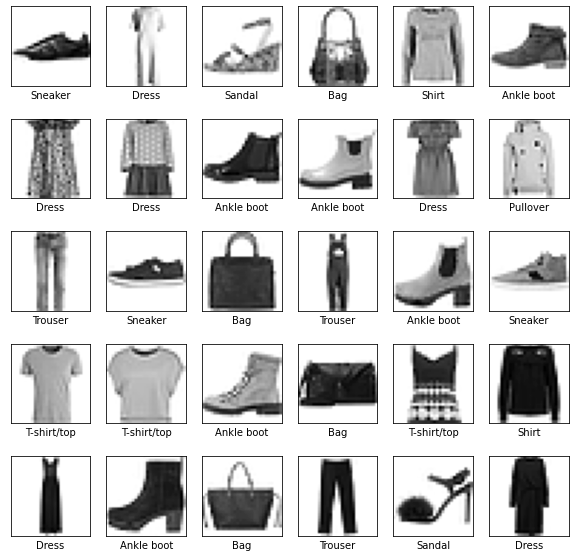

In [9]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(labels[y_train[i]])
plt.show()

## Preprocess for Sequential MLP

In [10]:
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

## Clean model

In [11]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [12]:
def plot_history(hs, epochs, metric):
    print()
    #plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

# Sequential MLP

1. How many hidden layers?
2. Ho many numbers of neurons?
3. Learning Rate?

In [13]:
def build_model(hp):

  np.random.seed(123) # Define the seed for numpy to have reproducible experiments.
  set_seed(1234) # Define the seed for Tensorflow to have reproducible experiments.

  model = keras.Sequential()
  model.add(Flatten(input_shape = (28,28))) #flattening the image
  model.add(Dropout(hp.Float('dropout', min_value = 0, max_value = 0.3, step=0.1)))
  for i in range(hp.Int('num_layers',1,4)):
#    model.add(Dense(units = hp.Int('hidden_units '+str(i),
#                              min_value = 32,
#                              max_value = 512,
#                              step = 32), 
#                    activation='relu'))
    
    model.add(Dense(units = hp.Choice('hidden_units '+str(i), [512,256,128,64,32]), 
                    activation='relu'))

    model.add(Dropout(hp.Float('dropout_hidden '+str(i),
                               min_value = 0,
                               max_value = 0.4,
                               step=0.1)))
  model.add(Dense(10, activation='softmax'))

  hp_learning_rate = hp.Choice('learning_rate', [1e-2,1e-3])

  optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate)
  
  

  model.compile(
      optimizer = optimizer,
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )
  return model

In [14]:
tuner = RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = 5,
    executions_per_trial=2,
    directory = 'my_dir_mlp',
    project_name = 'fmnist2')

In [15]:
es = EarlyStopping(monitor='val_accuracy', patience = 5)
with tf.device('/device:GPU:0'):
  tuner.search(x_train, y_train,
              epochs=50,
              validation_data=(x_val, y_val), 
              callbacks=[es])


Trial 5 Complete [00h 05m 04s]
val_loss: 0.30604346096515656

Best val_loss So Far: 0.30604346096515656
Total elapsed time: 00h 19m 02s
INFO:tensorflow:Oracle triggered exit


> In general, I noticed during the tuning process that a model that goes from general to specific (more hidden units at the first hidden layers, less hidden units at the last hidden layers) has better performance that the models that follows specific to general pattern.

In [16]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
tuner.results_summary()

Results summary
Results in my_dir_mlp/fmnist2
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
dropout: 0.30000000000000004
num_layers: 3
hidden_units 0: 64
dropout_hidden 0: 0.0
learning_rate: 0.001
hidden_units 1: 256
dropout_hidden 1: 0.0
hidden_units 2: 64
dropout_hidden 2: 0.1
Score: 0.30604346096515656
Trial summary
Hyperparameters:
dropout: 0.1
num_layers: 3
hidden_units 0: 128
dropout_hidden 0: 0.2
learning_rate: 0.001
hidden_units 1: 32
dropout_hidden 1: 0.30000000000000004
hidden_units 2: 512
dropout_hidden 2: 0.2
Score: 0.3349425345659256
Trial summary
Hyperparameters:
dropout: 0.0
num_layers: 3
hidden_units 0: 64
dropout_hidden 0: 0.1
learning_rate: 0.001
hidden_units 1: 32
dropout_hidden 1: 0.4
hidden_units 2: 512
dropout_hidden 2: 0.2
Score: 0.3612232804298401
Trial summary
Hyperparameters:
dropout: 0.30000000000000004
num_layers: 3
hidden_units 0: 128
dropout_hidden 0: 0.30000000000000004
learning_rate: 0.01
hidden_units 1

In [17]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
# Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max',patience=10, verbose=1)
#History
with tf.device('/device:GPU:0'):
  history = model.fit(
        x_train, 
        y_train,
        validation_data=(x_val, y_val),
        batch_size=8192,
        epochs=250,
        shuffle=True,
        callbacks=[es]
        )

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/250
6/6 [==============================] - 1s 78ms/step - loss: 2.1422 - accuracy: 0.2681 - val_loss: 1.7865 - val_accuracy: 0.4998
Epoch 2/250
6/6 [==============================] - 0s 30ms/step - loss: 1.5682 - accuracy: 0.5203 - val_loss: 1.1255 - val_accuracy: 0.6402
Epoch 3/250
6/6 [==============================] - 0s 35ms/step - loss: 1.0904 - accuracy: 0.6153 - val_loss: 0.8532 - val_accuracy: 0.6889
Epoch 4/250
6/6 [==============================] - 0s 31ms/step - loss: 0.9043 - accuracy: 0.6667 - val_loss: 0.7322 - val_accuracy: 0.7329
Epoch 5/250
6/6 [==============================] - 0s 31ms/step - loss: 0.7822 - accuracy: 0.7135 - val_loss: 0.6709 - val_accuracy: 0.7501
Epoch 6/250
6/6 [==============================] - 0s 33ms/step - loss: 0.7148 - accuracy: 0.7407 - val_loss: 0.6323 - val_accuracy: 0.7675
Epoch 7/250
6/6 [==============================] - 0s 29ms/step - loss: 0.6689 - accuracy: 0.7570 - val_loss: 0.5915 - val_accuracy: 0.7825
Epoch 8/250
6/6 [===

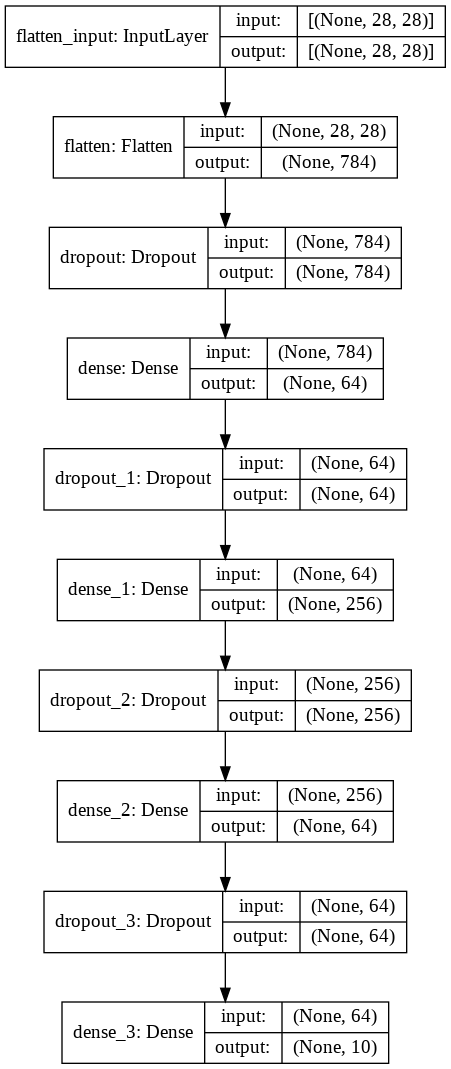

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True)

### curves

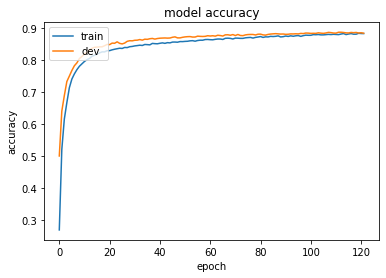

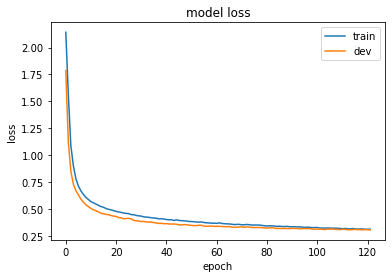

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [27]:
from sklearn.metrics import classification_report

#MLP on training set
train_pred = np.round(model.predict(x_train))
print('Training Set:')
print(classification_report(y_train, train_pred))
print('=======================================================')

#MLP on validation set
val_pred = np.round(model.predict(x_val))
print('Validation Set:')
print(classification_report(y_val, val_pred))
print('=======================================================')


#MLP on test set
test_pred = np.round(model.predict(x_test))
print('Test Set:')
print(classification_report(y_test, test_pred))

Training Set:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4798
           1       0.99      0.98      0.99      4781
           2       0.88      0.77      0.82      4795
           3       0.95      0.87      0.91      4816
           4       0.81      0.85      0.83      4798
           5       1.00      0.96      0.98      4789
           6       0.83      0.64      0.72      4782
           7       0.96      0.96      0.96      4841
           8       0.99      0.98      0.99      4803
           9       0.96      0.98      0.97      4797

   micro avg       0.92      0.88      0.90     48000
   macro avg       0.92      0.88      0.90     48000
weighted avg       0.92      0.88      0.90     48000
 samples avg       0.88      0.88      0.88     48000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Set:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1202
           1       0.99      0.97      0.98      1219
           2       0.87      0.76      0.81      1205
           3       0.92      0.84      0.88      1184
           4       0.79      0.83      0.81      1202
           5       0.99      0.95      0.97      1211
           6       0.81      0.61      0.70      1218
           7       0.94      0.94      0.94      1159
           8       0.98      0.96      0.97      1197
           9       0.93      0.97      0.95      1203

   micro avg       0.91      0.87      0.89     12000
   macro avg       0.91      0.87      0.88     12000
weighted avg       0.91      0.87      0.88     12000
 samples avg       0.87      0.87      0.87     12000

Test Set:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1000
           1       0.99      0.96      0.98      100

# CNN

In [ ]:
#from tensorflow.keras.layers import Conv2D,Activation, MaxPool2D


In [ ]:
x_train_cnn = x_train.reshape(len(x_train),28,28,1)

In [ ]:
train_images = x_train.reshape(len(x_train), 28, 28, 1)
val_images = x_val.reshape(len(x_val), 28, 28, 1)
test_images = x_test.reshape(len(x_test), 28, 28, 1)

# Να βάλω dropouts

In [ ]:
def build_model_cnn(hp):

  np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
  set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.


  model = keras.Sequential()
  model.add(Conv2D(filters = hp.Int('conv_1_filter',min_value = 32,max_value = 256,step = 32),
                   kernel_size = hp.Choice('conv_1_kernel',values = [3,5]),
                   activation = 'relu',
                   input_shape = (28,28,1)))
           
#      filters=hp.int("input_units",min_value=32,max_value=256,step=32),(3,3) ,input_shape=train_images[1:]))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  for i in range(hp.Int('hidden_layers',1,4)):
    model.add(Conv2D(filters = hp.Int('conv_1_filter '+str(i),min_value = 32,max_value = 256,step = 32),
                   kernel_size = hp.Choice('conv_1_kernel '+str(i),values = [3,5]),
                   activation = 'relu',
                   input_shape = (28,28,1)))
    model.add(Activation('relu'))
  
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('softmax'))

  hp_learning_rate = hp.Choice('learning_rate', [1e-2,1e-3])
  optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate)
  
  model.compile(
      optimizer = optimizer,
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )

  return model

In [ ]:
tuner_cnn = RandomSearch(
    build_model_cnn,
    objective = 'val_loss',
    max_trials = 5,
    executions_per_trial = 2,
    directory = 'my_dir_cnn',
    project_name = 'fmnist')

In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience = 5)
with tf.device('/device:GPU:0'):
  tuner_cnn.search(train_images, y_train,
              epochs=50,
              validation_data=(val_images, y_val), 
              callbacks=[es])

In [ ]:
# Get the optimal hyperparameters
best_hps_cnn=tuner_cnn.get_best_hyperparameters(num_trials=1)[0]
tuner_cnn.results_summary

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner_cnn.hypermodel.build(best_hps)
# Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max',patience=10, verbose=1)
#History
with tf.device('/device:GPU:0'):
  history = model.fit(
        train_images, 
        y_train,
        validation_data=(val_images, y_val),
        batch_size=8192,
        epochs=250,
        shuffle=True,
        callbacks=[es]
        )

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

#MLP on training set
train_pred = np.round(model.predict(train_images))
print('Training Set:')
print(classification_report(y_train, train_pred))
print('=======================================================')

#MLP on validation set
val_pred = np.round(model.predict(val_images))
print('Validation Set:')
print(classification_report(y_val, val_pred))
print('=======================================================')

#MLP on test set
test_pred = np.round(model.predict(test_images))
print('Test Set:')
print(classification_report(y_test, test_pred))

# Functional

In [ ]:
optimizer = SGD(lr=0.01, momentum= 0.9, nesterov = True)
#optimizer = Adam(lr=0.01)

es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 10)

epochs = 100
model.compile(loss = 'sparse_categorical_crossentropy', #Computes the crossentropy loss between the labels and predictions.
              optimizer = optimizer,
              metrics=['accuracy'])
history = model.fit(x_train,y_train, batch_size=1024, epochs = epochs, validation_split=0.2, callbacks=[es])

#### SGD

In [ ]:
print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
#print("Test Loss      : {0:.5f}".format(history[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
#print("Test Accuracy      : {0:.5f}".format(history[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP Seq': history}, epochs=epochs, metric='loss')
plot_history(hs={'MLP Seq': history}, epochs=epochs, metric='accuracy')

#### ADAM

In [ ]:
print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
#print("Test Loss      : {0:.5f}".format(history[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
#print("Test Accuracy      : {0:.5f}".format(history[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP Seq': history}, epochs=epochs, metric='loss')
plot_history(hs={'MLP Seq': history}, epochs=epochs, metric='accuracy')

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 16
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
x_ticks = np.arange(0, no_epochs + 1, 5)
x_ticks [0] += 1
plt.xticks(x_ticks)
plt.ylim((0, 1))
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title("optimizer: ADAM with momentum and Nesterov momentum-early stopping")
plt.legend()
plt.show()

## Preprocess for Functional

In [ ]:
batch_size = 128
classes = 10
epochs = 100
# Lets flatten the shapes
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]) 
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255 #Standardization of the pixels (max = 255)
x_test /= 255 #Standardization
y_train = to_categorical(y_train,classes) #autocreate a category vector
y_test = to_categorical(y_test,classes) #autocreate a category vector

## Testig some Functional MLPs
Trials based on class lab

In [ ]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [ ]:
def train_model(
        train_data,
        train_labels,
        optimizer,
        epochs=100,
        batch_size=128,
        hidden_layers=0,
        hidden_activation='relu',
        output_activation='softmax',
        verbose=0):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=(784,),
        name='Input'
    )

    x = input
    # Define the remaining hidden layers.
    units = 256
    for i in range(hidden_layers):
        x = Dense(
            units=units/(i+1),
            kernel_initializer='glorot_uniform',
            activation=hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        
    # Define the output layer.
    output = Dense(
        units=classes,
        kernel_initializer='glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=x_train,
        y=y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=verbose,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs

### SGD

In [ ]:
# Using SGD
optimizer = SGD(lr=0.01)

# Logistic Regression
lr_model_sgd, lr_hs_sgd = train_model(
    train_data=x_train,
    train_labels=y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=0,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
lr_eval_sgd = lr_model_sgd.evaluate(x_test, y_test, verbose=1)
clean_up(model=lr_model_sgd)

In [ ]:
tf.keras.utils.plot_model(lr_model_sgd, show_shapes=True)

In [ ]:
print("Train Loss     : {0:.5f}".format(lr_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(lr_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(lr_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(lr_hs_sgd.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(lr_hs_sgd.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(lr_eval_sgd[1]))

# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_sgd}, epochs=epochs, metric='accuracy')

In [ ]:
# Using SGD
optimizer = SGD(lr=0.01)

# MLP
mlp_model_sgd, mlp_hs_sgd = train_model(
    train_data=x_train,
    train_labels=y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=1,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp_eval_sgd = mlp_model_sgd.evaluate(x_test, y_test, verbose=1)
clean_up(model=mlp_model_sgd)

In [ ]:
tf.keras.utils.plot_model(mlp_model_sgd, show_shapes=True)

In [ ]:
print("Train Loss     : {0:.5f}".format(mlp_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp_hs_sgd.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp_hs_sgd.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_sgd[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP': mlp_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'MLP': mlp_hs_sgd}, epochs=epochs, metric='accuracy')

In [ ]:
# Using SGD
optimizer = SGD(lr=0.01)

# MLP
mlp2_model_sgd, mlp2_hs_sgd = train_model(
    train_data=x_train,
    train_labels=y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=2,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp2_eval_sgd = mlp2_model_sgd.evaluate(x_test, y_test, verbose=1)
clean_up(model=mlp2_model_sgd)

In [ ]:
tf.keras.utils.plot_model(mlp2_model_sgd, show_shapes=True)


In [ ]:
print("Train Loss     : {0:.5f}".format(mlp2_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp2_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp2_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp2_hs_sgd.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp2_hs_sgd.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp2_eval_sgd[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP': mlp_hs_sgd,'MLP2': mlp2_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'MLP': mlp_hs_sgd, 'MLP2': mlp2_hs_sgd}, epochs=epochs, metric='accuracy')

In [ ]:
# Using SGD
optimizer = SGD(lr=0.01)

# MLP
mlp3_model_sgd, mlp3_hs_sgd = train_model(
    train_data=x_train,
    train_labels=y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=3,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp3_eval_sgd = mlp3_model_sgd.evaluate(x_test, y_test, verbose=1)
clean_up(model=mlp3_model_sgd)

In [ ]:
tf.keras.utils.plot_model(mlp3_model_sgd, show_shapes=True)

In [ ]:
print("Train Loss     : {0:.5f}".format(mlp3_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp3_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp3_hs_sgd.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp3_hs_sgd.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_sgd[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP2': mlp2_hs_sgd,'MLP3': mlp3_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'MLP2': mlp2_hs_sgd,'MLP3': mlp3_hs_sgd}, epochs=epochs, metric='accuracy')

### ADAM


In [ ]:
# Using Adam
optimizer = Adam()

# MLP
mlp_model_adam, mlp_hs_adam = train_model(
    train_data=x_train,
    train_labels=y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=1,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp_eval_adam = mlp_model_adam.evaluate(x_test, y_test, verbose=1)
clean_up(model=mlp_model_adam)

In [ ]:
tf.keras.utils.plot_model(mlp_model_adam, show_shapes=True)


In [ ]:
# Using Adam
optimizer = Adam()

# MLP
mlp2_model_adam, mlp2_hs_adam = train_model(
    train_data=x_train,
    train_labels=y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=2,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp2_eval_adam = mlp2_model_adam.evaluate(x_test, y_test, verbose=1)
clean_up(model=mlp2_model_adam)

In [ ]:
tf.keras.utils.plot_model(mlp2_model_adam, show_shapes=True)

In [ ]:
# Using Adam
optimizer = Adam()

# MLP
mlp3_model_adam, mlp3_hs_adam = train_model(
    train_data=x_train,
    train_labels=y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=3,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp3_eval_adam = mlp3_model_adam.evaluate(x_test, y_test, verbose=1)
clean_up(model=mlp3_model_adam)

In [ ]:
tf.keras.utils.plot_model(mlp3_model_adam, show_shapes=True)


In [ ]:
print("========== MLP ==========")
print("Train Loss     : {0:.5f}".format(mlp_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_adam[1]))

print("========== MLP2 ==========")

print("Train Loss     : {0:.5f}".format(mlp2_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp2_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp2_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp2_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp2_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp2_eval_adam[1]))

print("========== MLP3 ==========")

print("Train Loss     : {0:.5f}".format(mlp3_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp3_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp3_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp3_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp3_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp3_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(hs={'MLP': mlp_hs_adam, 'MLP2': mlp2_hs_adam, 'MLP3': mlp3_hs_adam}, epochs=epochs, metric='loss')
plot_history(hs={'MLP': mlp_hs_adam, 'MLP2': mlp2_hs_adam, 'MLP3': mlp3_hs_adam}, epochs=epochs, metric='accuracy')

In [ ]:
mlp2_hs_sgd